In [1]:
library("tidyverse")
library("data.table")
library("cowplot")

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

Attaching package: ‘data.table’


The following objects are masked from ‘package:lubridate’:

    hour, isoweek, mday, minute, month, quarter, second, wday, week,
    yday, year


The following objects are masked from ‘package:dplyr’:

    between, first, last


The following object is masked from ‘package:purrr’:

    transpose



Attaching package: ‘cowplot’


The following object is masked from ‘package:lubridate’:

    stamp




In [2]:
set.seed(1)
df <- fread("/nfs/research/birney/users/saul/nextflow/medaka_behaviour_pilot/hmm/time_step0.08_n_states15_hmm.csv.gz")
df[, mean_dist := log10(mean(distance)), by = hmm_state]
tmp <- df[, .(hmm_state, mean_dist)] |> distinct() |> as.data.table()
tmp[, hmm_state_recoded := rank(mean_dist)]
df <- merge(df, tmp, by = c("hmm_state", "mean_dist"))
df[, assay := ifelse(grepl("_no_", id), "Novel object", "Open field")]
df_no <- df[assay == "Novel object"]
df_of <- df[assay == "Open field"]

In [3]:
annot_df <- data.table(
    hmm_state_recoded = 1,
    distance = 1,
    angle = c(0, 90, -90, 180),
    label = c("0", "90", "-90", "±180")
)
annot_df

hmm_state_recoded,distance,angle,label
<dbl>,<dbl>,<dbl>,<chr>
1,1,0,0
1,1,90,90
1,1,-90,-90
1,1,180,±180


In [6]:
p <- ggplot() +
    geom_label(data = annot_df, aes(x = angle, y = distance, label = label), size = 5, label.size = NA) +
    geom_point(data = df_of, aes(x = angle/pi*180, y = log10(distance)), shape = ".", alpha = 0.01) +
    coord_polar(start = pi) +
    scale_y_continuous(breaks = c(-3, -1, 1)) +
    scale_x_continuous(
        labels = c(),
        breaks = c(-90, 0, 90, 179.999) # cannot plot exactly 180
    ) +
    facet_wrap(~ hmm_state_recoded, nrow = 2, labeller = as_labeller(function(i){sprintf("HMM state %s", i)})) +
    labs(x = "Angle (deg)", y = bquote(Distance~(Log[10](px)))) +
    theme_linedraw(18) +
    theme(
        legend.position = "none",
        panel.background = element_rect(fill = "white"),
        strip.background = element_blank(),
        strip.text = element_text(color = "black"),
        panel.grid.major = element_line(color = "gray30")
    )

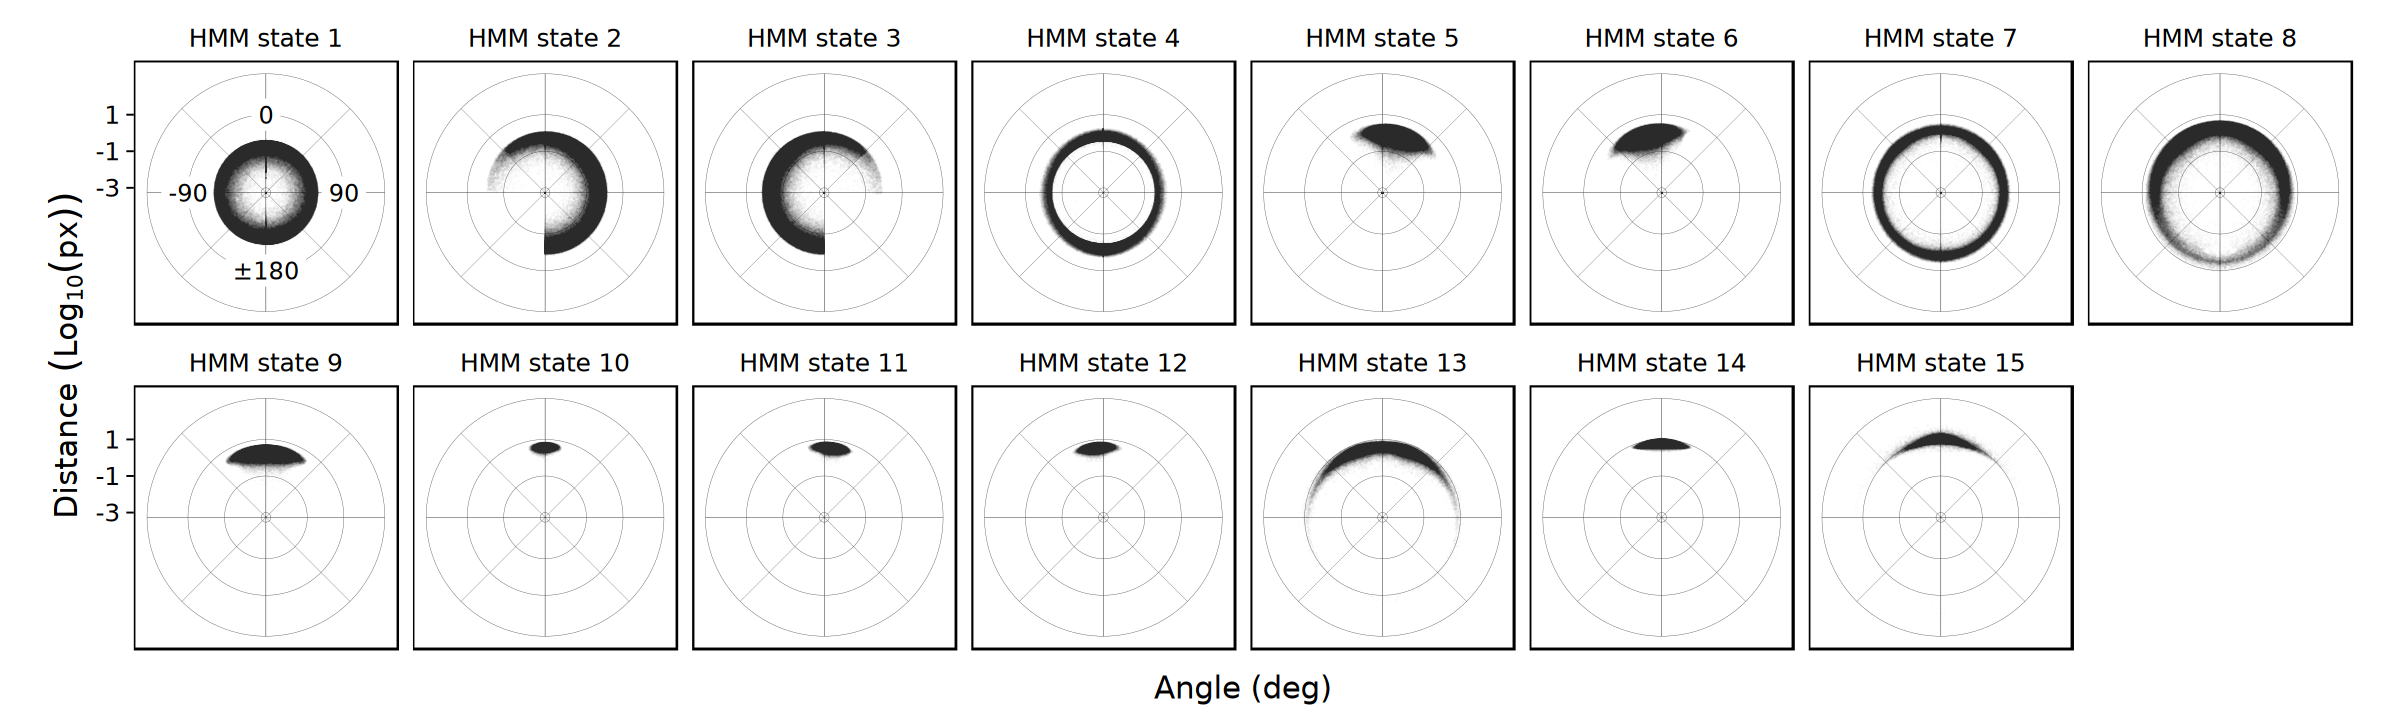

In [9]:
options(repr.plot.width = 20, repr.plot.height = 6)
p